# How to perform spectral component separation?

In this tutorial you will learn how to use spectral component separation to disentangle the morphological properties of overlapping sources.

As usual we start by importing the gammalib, ctools, and cscripts Python modules.

In [1]:
import gammalib
import ctools
import cscripts

We also import the matplotlib package for plotting.

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

## Simulated dataset

For the tutorial we will simulate a small CTA dataset. We start by defining the Instrument Response Functions and energy range that will be used all along.

In [3]:
caldb = 'prod2'
irf   = 'South_5h'
emin  = 0.1   # TeV
emax  = 160.0 # TeV

We will simulate an observation of the region around the famous sources HESS J1825-137 and HESS J1826-130 based on a very simple sky model. We will consider two pointings of a few hours wobbling around the sources' position.

We start by writing the pointing directions and times to an ASCII file.

In [4]:
pointing_file = 'pointings.txt'

# open file
f = open(pointing_file, 'w')
# header
f.write('id,ra,dec,tmin,tmax\n')
# pointings
f.write('0001,275.65,-13.78,0.,10800.\n')
f.write('0002,277.25,-13.78,11000.,21800.\n')

# close file
f.close()

Then we use the csobsdef script to convert the list of pointings into an observation definition XML file.

In [5]:
obsdef = cscripts.csobsdef()
obsdef['inpnt'] = pointing_file
obsdef['caldb'] = caldb
obsdef['irf'] = irf
obsdef['emin'] = emin
obsdef['emax'] = emax
obsdef['rad'] = 5.
obsdef.run()

Finally we use ctobssim to perform the observation simulation.

In [6]:
obssim = ctools.ctobssim(obsdef.obs())
obssim['inmodel']   = '$CTOOLS/share/models/hess1825_26.xml'

obssim.run()

## Skymap inspection and preliminary likelihood fit

*This section showcases a possible path to get to perform a spectral component separation. If you are here because you have an application in which you know the spectrum of your sources of interest, and you want just to learn how to perform the spectral component separation, please jump to the next section.*

As usual a great way to inspect the data is making a skymap using ctskymap.

In [7]:
skymap = ctools.ctskymap(obssim.obs())
skymap['emin']        = emin
skymap['emax']        = emax
skymap['nxpix']       = 200
skymap['nypix']       = 200
skymap['binsz']       = 0.02
skymap['proj']        = 'TAN'
skymap['coordsys']    = 'CEL'
skymap['xref']        = 276.45
skymap['yref']        = -13.78
skymap['bkgsubtract'] = 'NONE'
skymap.run()

Below we inspect the skymap by using matpltolib.

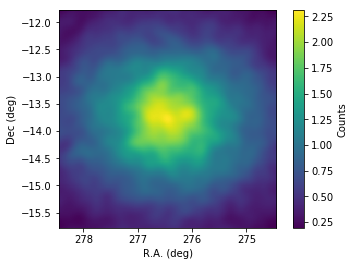

In [8]:
# Slightly smooth the map for display to suppress statistical fluctuations
skymap.skymap().smooth('GAUSSIAN',0.1)

fig = plt.figure()
ax = plt.subplot()
plt.imshow(skymap.skymap().array(),origin='lower',
           extent=[276.45+0.02*100,276.45-0.02*100,-13.78-0.02*100,-13.78+0.02*100])
           # boundaries of the coord grid
ax.set_xlabel('R.A. (deg)')
ax.set_ylabel('Dec (deg)')
cbar = plt.colorbar()
cbar.set_label('Counts')

A large blob of emission appears at the center of the map. It coincides with the source HESS J1825-137. Past observations have indicated that HESS J1826-130 has a harder spectrum than HESS J1825-137. Let's peek at a skymap above 10 TeV.

In [9]:
skymap = ctools.ctskymap(obssim.obs())
skymap['emin']        = 10. #TeV
skymap['emax']        = emax
skymap['nxpix']       = 200
skymap['nypix']       = 200
skymap['binsz']       = 0.02
skymap['proj']        = 'TAN'
skymap['coordsys']    = 'CEL'
skymap['xref']        = 276.45
skymap['yref']        = -13.78
skymap['bkgsubtract'] = 'NONE'
skymap.run()

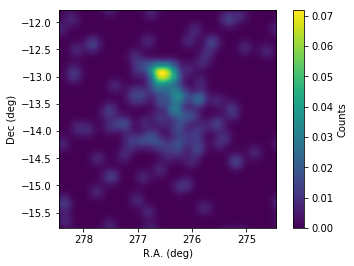

In [10]:
# Slightly smooth the map for display to suppress statistical fluctuations
skymap.skymap().smooth('GAUSSIAN',0.1)

fig = plt.figure()
ax = plt.subplot()
plt.imshow(skymap.skymap().array(),origin='lower',
           extent=[276.45+0.02*100,276.45-0.02*100,-13.78-0.02*100,-13.78+0.02*100])
           # boundaries of the coord grid
ax.set_xlabel('R.A. (deg)')
ax.set_ylabel('Dec (deg)')
cbar = plt.colorbar()
cbar.set_label('Counts')

Indeed, emission above 10 TeV is concentrated on a spot North of the low-energy blob coincident with the position of HESS J1826-130. How can we disentangle the morphology of the two sources based on our observations?

One of the traditional techniques to disentangle multiple overlapping sources is using a 3D likelihood analysis based on some guess of the sources' morphology and spectra. However, this often implies to choose a simplistic (analytical) model for the sources' morphology. Below we will test another approach, that consists in determining the morphology from the data using some knowledge of their spectra.

For our exercise we guess the spectra of the two components via a preliminary likelihood analysis. For this we use a tentative sky model inspired by the skymaps we have inspected. We include in the model two disks with centre and extension eye-balled from the low-energy blob and high-energy spot. Their parameters are not fit to the data here for the sake of a shorter execution time. The morphology will be determined from the data later. However, at a cost of a longer computing time you could fit the spatial model parameters in this step.

For both components we will assume a power-law spectrum, with and index of 2.5 for the soft component and an index of 1.5 for the hard component, and a flux at 1 TeV approximately 10% and 1% of the Crab nebula, respectively. These spectral parameters are going to be fit to the data.

In [11]:
# model container
models = gammalib.GModels()

# low-energy blob
centre = gammalib.GSkyDir()
centre.radec_deg(276.5,-13.75)
spatial = gammalib.GModelSpatialRadialDisk(centre,0.5)
# free source centre
spatial['RA'].fix()
spatial['DEC'].fix()
spatial['Radius'].fix()
spectral = gammalib.GModelSpectralPlaw(4.e-18,-2.5,gammalib.GEnergy(1.,'TeV'))
source = gammalib.GModelSky(spatial,spectral)
source.name('HESS J1825-137')
models.append(source)

# high-energy spot
centre = gammalib.GSkyDir()
centre.radec_deg(276.5,-13)
spatial = gammalib.GModelSpatialRadialDisk(centre,0.1)
# free source centre
spatial['RA'].fix()
spatial['DEC'].fix()
spatial['Radius'].fix()
spectral = gammalib.GModelSpectralPlaw(4.e-19,-1.5,gammalib.GEnergy(1.,'TeV'))
source = gammalib.GModelSky(spatial,spectral)
source.name('HESS J1826-130')
models.append(source)

# instrumental background
# power law spectral correction with pivot energy at 1 TeV
spectral = gammalib.GModelSpectralPlaw(1, 0, gammalib.GEnergy(1, 'TeV'))
bkgmodel = gammalib.GCTAModelIrfBackground(spectral)
bkgmodel.name('Background')
bkgmodel.instruments('CTA')
# append to models
models.append(bkgmodel)

<gammalib.cta.GCTAModelIrfBackground; proxy of <Swig Object of type 'GCTAModelIrfBackground *' at 0x1129b32a0> >

We copy the simulated observations and append to them our initial sky model.

In [12]:
obs = obssim.obs().copy()
obs.models(models)

We are going to start with a stacked analysis. We bin the events, and then attach to the stacked observations the stacked response. Note that if the dataset is small it may be convenient to use an unbinned analysis in lieu of the stacked analysis for this step.

In [13]:
# Bin events
cntcube = ctools.ctbin(obs)
cntcube['usepnt']   = False
cntcube['ebinalg']  = 'LOG'
cntcube['xref']     = 276.45
cntcube['yref']     = -13.78
cntcube['binsz']    = 0.02
cntcube['nxpix']    = 200
cntcube['nypix']    = 200
cntcube['enumbins'] = 40
cntcube['emin']     = emin
cntcube['emax']     = emax
cntcube['coordsys'] = 'CEL'
cntcube['proj']     = 'TAN'
cntcube.run()

# Extract counts cube
cube = cntcube.cube()

# Compute stacked response
response = cscripts.obsutils.get_stacked_response(obs,cube)

# Copy stacked observations
stacked_obs = cntcube.obs().copy()

# Append stacked response
stacked_obs[0].response(response['expcube'], response['psfcube'],response['bkgcube'])

# Set stacked models
stacked_obs.models(response['models'])

Now we can run the preliminary likelihood analysis in which the spectral parameters for the two sources are fit to the data.

In [14]:
like = ctools.ctlike(stacked_obs)
like.run()

Let's check that the fit was successful.

In [15]:
print(like.opt())

=== GOptimizerLM ===
 Optimized function value ..: 122722.355
 Absolute precision ........: 0.005
 Acceptable value decrease .: 2
 Optimization status .......: converged
 Number of parameters ......: 18
 Number of free parameters .: 6
 Number of iterations ......: 6
 Lambda ....................: 1e-09


We also check the fitted models.

In [16]:
print(like.obs().models())

=== GModels ===
 Number of models ..........: 3
 Number of parameters ......: 18
=== GModelSky ===
 Name ......................: HESS J1825-137
 Instruments ...............: all
 Observation identifiers ...: all
 Model type ................: ExtendedSource
 Model components ..........: "RadialDisk" * "PowerLaw" * "Constant"
 Number of parameters ......: 7
 Number of spatial par's ...: 3
  RA .......................: 276.5 deg (fixed,scale=1)
  DEC ......................: -13.75 deg (fixed,scale=1)
  Radius ...................: 0.5 [0.0002778,infty[ deg (fixed,scale=1)
 Number of spectral par's ..: 3
  Prefactor ................: 6.34330444443657e-18 +/- 3.01336043884925e-19 [0,infty[ ph/cm2/s/MeV (free,scale=4e-18,gradient)
  Index ....................: -2.344118164095 +/- 0.0376367951224068 [10,-10]  (free,scale=-2.5,gradient)
  PivotEnergy ..............: 1000000 MeV (fixed,scale=1000000,gradient)
 Number of temporal par's ..: 1
  Normalization ............: 1 (relative value) (fixed

As guessed from the skymaps HESS J1826-130 is fainter than HESS J1825-137, but its spectrum is rather harder. We will use the values of the spectral indices obtained from this likelihood analysis to derive the source morphology below.

However, we first check the fit residuals. Let's start by inspecting the spectral residuals using csresspec.

In [17]:
resspec = cscripts.csresspec(like.obs())
resspec['algorithm'] = 'SIGNIFICANCE'
resspec['components'] = True
resspec['outfile'] = 'resspec.fits'
resspec.execute()

We can use an example script to display the residuals.

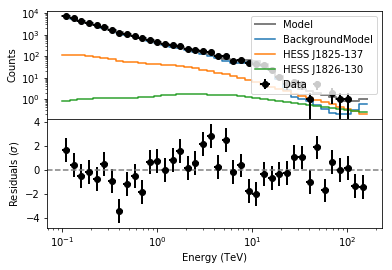

In [18]:
import sys
import os
sys.path.append(os.environ['CTOOLS']+'/share/examples/python/')

from show_residuals import plot_residuals
plot_residuals('resspec.fits','',0)

The model reproduces reasonably well the data spectrally (although not perfectly). We will also check the spatial residuals using csresmap.

In [19]:
resmap = cscripts.csresmap(like.obs())
resmap['algorithm'] = 'SIGNIFICANCE'
resmap.run()

We inspect the map to check the spatial residuals.

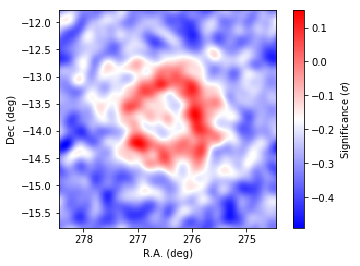

In [20]:
# Slightly smooth the map for display to suppress statistical fluctuations
resid = resmap._resmap.copy()
resid.smooth('GAUSSIAN',0.1)
# Plotting
fig = plt.figure()
ax  = plt.subplot()
plt.imshow(resid.array(),origin='lower', cmap='bwr',
           extent=[276.45+0.02*100,276.45-0.02*100,-13.78-0.02*100,-13.78+0.02*100])
           # Boundaries of the coord grid
ax.set_xlabel('R.A. (deg)')
ax.set_ylabel('Dec (deg)')
cbar = plt.colorbar()
cbar.set_label('Significance ($\sigma$)')

The spatial residuals are small, indicating that the model is close enough to the data. However, the structures in the residuals indicate that the morphological models adopted may not accurately represent the data.

## Stacked spectral component separation

If we are confident that the spectral models we have at hand represent the data well, we can use this information to determine the morphology of the emission associated with each spectral component from the data by using csscs. First of all we will perform the spectral component separation using the stacked dataset. **A stacked analysis is usually the fastest option for csscs**. However, an unbinned analysis is also possible. 

As a preliminary step we will change the spatial models for the two components to be separated. The script uses the spatial model provided as prior, so for a disk the flux outside the disk radius would always be null. If you have a reasonable prior you can use it in the component separation, but **it is recommended to use a spatial model without sharp boundaries (e.g., Gaussian)**. Since in this case we do not know what the morphology of the two sources is, we will start with an isotropic distribution. 

In [21]:
# copy the fitted models
fit_obs = like.obs().copy()

# replace disks with isotropic model
for model in fit_obs.models():
    if model.name() == 'HESS J1825-137' or model.name() == 'HESS J1826-130': 
        model.spatial(gammalib.GModelSpatialDiffuseConst())

The essential information to be provided to csscs is:

- the geometry of the output maps; for every bin in the output map a dedicated likelhood analysis will be used to determine the fluxes of the sources of interest; **make sure to have a region just big enough and a grid step just fine enough for your purposes** since increasing the number of bins will proportionally increase the computation time; 

- the list of the sources of interest;

- the energy range for the analysis;

- the radius (``rad``) of the region of interest to be used for the spectral component separation centred on each bin of the output maps; note that the value of this parameter sets the correlation scale between neighbour pixels in the output maps, and it must be at least sqrt(2) times ``binsz`` to fully cover the input dataset; furthemore, **``rad`` must be large enough to ensure that you have enough statististics to perform a likelihood fit**.

You can decide if you want to leave free in the fit the background model (true by default) and other background gamma-ray sources (false by default, we have none in the exemple we are considering).

In [22]:
scs1 = cscripts.csscs(fit_obs)
scs1['srcnames']  = 'HESS J1825-137;HESS J1826-130'
scs1['emin']      = emin
scs1['emax']      = emax
scs1['nxpix']     = 20
scs1['nypix']     = 20
scs1['binsz']     = 0.1
scs1['rad']       = 0.2
scs1['proj']      = 'TAN'
scs1['coordsys']  = 'CEL'
scs1['xref']      = 276.45
scs1['yref']      = -13.78
scs1.run()

Now we can inspect the maps of the fluxes from the two sources. We will set a minimum flux for display to avoid being confused by noisy bins. In fact the script has calculated also the flux uncertainty in each bin (accessible through the ``flux_error`` method) and the detection significance (accessible through the ``ts`` method), that you can use to filter more intelligently the maps. We did not request this, but one could also have flux upper limits computed (``calc_ulimit`` parameter).

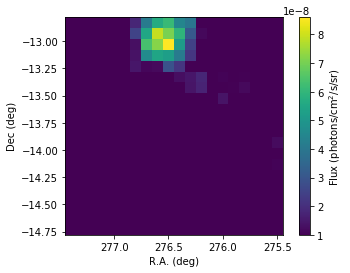

In [23]:
flux_1826 = scs1.flux('HESS J1826-130')

# Plotting
fig = plt.figure()
ax  = plt.subplot()
plt.imshow(flux_1826.array(),origin='lower', vmin = 1.e-8,
           extent=[276.45+0.1*10,276.45-0.1*10,-13.78-0.1*10,-13.78+0.1*10])
           # Boundaries of the coord grid
ax.set_xlabel('R.A. (deg)')
ax.set_ylabel('Dec (deg)')
cbar = plt.colorbar()
cbar.set_label('Flux (photons/cm$^2$/s/sr)')

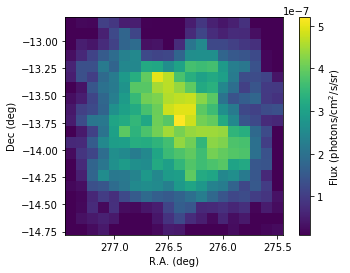

In [24]:
flux_1825 = scs1.flux('HESS J1825-137')

# Plotting
fig = plt.figure()
ax  = plt.subplot()
plt.imshow(flux_1825.array(),origin='lower', vmin = 1.e-8,
           extent=[276.45+0.1*10,276.45-0.1*10,-13.78-0.1*10,-13.78+0.1*10])
           # Boundaries of the coord grid
ax.set_xlabel('R.A. (deg)')
ax.set_ylabel('Dec (deg)')
cbar = plt.colorbar()
cbar.set_label('Flux (photons/cm$^2$/s/sr)')

As you can see the hard emission is confined in the North. The soft emission blob seems to have an elongated shape.

## On/Off spectral component separation

What if you don't have a reliable background model to perform a 3D analysis? You can still perform a spectral component separation using the On/Off technique as long as you have a prior on the source's spectra.

For this **we need first of all to compute an exclusion map**, i.e., a map of the region where there is significant gamma-ray emission, so that we can exclude it from background computation. We can do this by using ctskymap with the ``RING`` background subtraction method. Since we are dealing with a large source we will use rather large ROI and ring regions.

In [25]:
skymap = ctools.ctskymap(obssim.obs())
skymap['emin']        = emin
skymap['emax']        = emax
skymap['nxpix']       = 200
skymap['nypix']       = 200
skymap['binsz']       = 0.02
skymap['proj']        = 'TAN'
skymap['coordsys']    = 'CEL'
skymap['xref']        = 276.45
skymap['yref']        = -13.78
skymap['bkgsubtract'] = 'RING'
skymap['roiradius']   = 0.5
skymap['inradius']    = 1.0
skymap['outradius']   = 1.5
skymap['iterations']  = 3
skymap['threshold']   = 5 # sigma
skymap.run()

Let's inspect the exclusion map.

Text(0,0.5,'Dec (deg)')

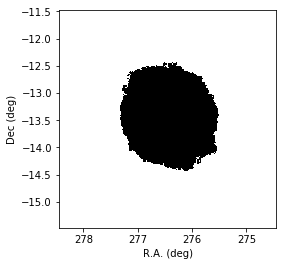

In [26]:
fig = plt.figure()
ax = plt.subplot()
plt.imshow(skymap.exclusion_map().map().array(), origin='lower', cmap = 'binary',
           extent=[276.45+0.02*100,276.45-0.02*100,-13.48-0.02*100,-13.48+0.02*100])
           # boundaries of the coord grid
ax.set_xlabel('R.A. (deg)')
ax.set_ylabel('Dec (deg)')

To use csscs in On/Off mode we need to go back to using the event lists. We modify the associated models to the latest version obtained from the global likelihood fit.

In [27]:
obs.models(like.obs().models())

Note that **in On/Off mode if there are multiple sources csscs will use only the spectral models for the sources, and their emission within each ROI for component separation will be assumed by default to be isotropic**. We will not use the background model, we'll just assume that the background rate of the reflected background regions is the same as in the ROI.

*This step is rather time consuming, and should take at least a couple of hours to complete on a normal laptop. This is a good time for you to grab lunch or to read that review paper you always meant to.*

In [28]:
scs2 = cscripts.csscs(obs)
scs2['srcnames']      = 'HESS J1825-137;HESS J1826-130'
scs2['emin']          = emin
scs2['emax']          = emax
scs2['nxpix']         = 20
scs2['nypix']         = 20
scs2['binsz']         = 0.1
scs2['rad']           = 0.2
scs2['proj']          = 'TAN'
scs2['coordsys']      = 'CEL'
scs2['xref']          = 276.45
scs2['yref']          = -13.78
scs2['method']        = 'ONOFF'
scs2['use_model_bkg'] = False
scs2['enumbins']      = 30
scs2.exclusion_map(skymap.exclusion_map())
scs2.run()

We visualize below the flux maps, which are quite consistent with those obtained using the stacked analysis.

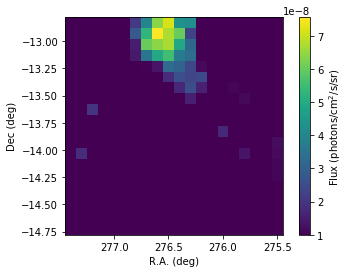

In [29]:
flux_1826 = scs2.flux('HESS J1826-130')

# Plotting
fig = plt.figure()
ax  = plt.subplot()
plt.imshow(flux_1826.array(),origin='lower', vmin = 1.e-8,
           extent=[276.45+0.1*10,276.45-0.1*10,-13.78-0.1*10,-13.78+0.1*10])
           # Boundaries of the coord grid
ax.set_xlabel('R.A. (deg)')
ax.set_ylabel('Dec (deg)')
cbar = plt.colorbar()
cbar.set_label('Flux (photons/cm$^2$/s/sr)')

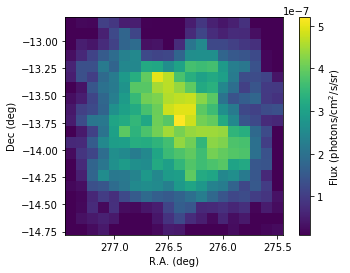

In [30]:
flux_1825 = scs1.flux('HESS J1825-137')

# Plotting
fig = plt.figure()
ax  = plt.subplot()
plt.imshow(flux_1825.array(),origin='lower', vmin = 1.e-8,
           extent=[276.45+0.1*10,276.45-0.1*10,-13.78-0.1*10,-13.78+0.1*10])
           # Boundaries of the coord grid
ax.set_xlabel('R.A. (deg)')
ax.set_ylabel('Dec (deg)')
cbar = plt.colorbar()
cbar.set_label('Flux (photons/cm$^2$/s/sr)')